# Selected models visiting L-state conductance

In [ ]:
selected_models = ['cWza-S355C_conformation0_0257',
                   'cWza-S355C_conformation0_0387',
                   'cWza-S355C_conformation0_0617',
                   'cWza-S355C_conformation0_0722',
                   'cWza-S355C_conformation1_0050',
                   'cWza-S355C_conformation1_0301',
                   'cWza-S355C_conformation1_0407',
                   'cWza-S355C_conformation1_0579',
                   'cWza-S355C_conformation1_0833',
                   'cWza-Y373C_conformation1_0213',
                   'cWza-Y373C_conformation1_0325',
                   'cWza-Y373C_conformation1_0337',
                   'cWza-Y373C_conformation1_0646']

## Conductance and radius of gyration analysis

In [ ]:
import MDAnalysis as mda
from MDAnalysis.analysis.base import (AnalysisBase,
                                      AnalysisFromFunction,
                                      analysis_class)
import pickle
import numpy as np
import pandas as pd
from statistics import median
import matplotlib.pyplot as plt
%matplotlib inline

Load conductance data

In [ ]:
filepath = 'data/Gpred_Rmin_timeseries_cleaned.pickle'
df_conductance = pd.DataFrame.from_dict(pd.read_pickle(filepath))

Radius of gyration analysis

In [ ]:
def radgyr(atomgroup, masses, total_mass=None):
    # coordinates change for each frame
    coordinates = atomgroup.positions
    center_of_mass = atomgroup.center_of_mass()

    # get squared distance from center
    ri_sq = (coordinates-center_of_mass)**2
    # sum the unweighted positions
    sq = np.sum(ri_sq, axis=1)
    sq_x = np.sum(ri_sq[:,[1,2]], axis=1) # sum over y and z
    sq_y = np.sum(ri_sq[:,[0,2]], axis=1) # sum over x and z
    sq_z = np.sum(ri_sq[:,[0,1]], axis=1) # sum over x and y

    # make into array
    sq_rs = np.array([sq, sq_x, sq_y, sq_z])

    # weight positions
    rog_sq = np.sum(masses*sq_rs, axis=1)/total_mass
    # square root and return
    return np.sqrt(rog_sq)

List of trajectories with close-to, transient, short-lived L-state conductance

In [ ]:
rg_results = {}

rg_results['backbone'] = {}
for i in range(len(selected_models)):
    model_name = selected_models[i]
    traj_file = 'data/'+model_name+'/md_100ns.xtc'
    top_file = 'data/'+model_name+'/md_100ns.tpr'

    u = mda.Universe(top_file, traj_file)
    protein = u.select_atoms('backbone and protein')

    rog = AnalysisFromFunction(radgyr, u.trajectory,
                               protein, protein.masses,
                               total_mass=np.sum(protein.masses))
    rog.run()
    
    rg_results['backbone'][model_name] = rog.results['timeseries'].T

In [ ]:
rg_results['allatoms'] = {}
for i in range(len(selected_models)):
    model_name = selected_models[i]
    traj_file = 'data/'+model_name+'/md_100ns.xtc'
    top_file = 'data/'+model_name+'/md_100ns.tpr'

    u = mda.Universe(top_file, traj_file)
    protein = u.select_atoms('protein')

    rog = AnalysisFromFunction(radgyr, u.trajectory,
                               protein, protein.masses,
                               total_mass=np.sum(protein.masses))
    rog.run()
    
    rg_results['allatoms'][model_name] = rog.results['timeseries'].T

## Conductance and backbone radius of gyration

In [ ]:
for i in range(len(selected_models)):
    fig,ax = plt.subplots(2,1,figsize=(16,4),sharex=True,dpi=100)
    
    model_name = selected_models[i]
    
    # Conductance timeseries plots
    X = df_conductance[model_name]; X0 = median(X)
    
    ax[0].plot(X, color='black',alpha=0.75, lw=0.75)
    ax[0].fill_between(x=range(len(X)),y1=X0, y2=X, color='blue',alpha=0.35)
    
    ax[0].axhline(y=0.38, label='L-state (EXPTL): 0.38 nS', color='green', linestyle='--', lw=2)
    ax[0].axhline(y=0.73, label='H-state, Y373C (EXPTL): 0.73 nS', color='orange', linestyle='--', lw=2)
    ax[0].axhline(y=0.97, label='H-state (EXPTL): 0.97 nS', color='blue', linestyle='--', lw=2)
    
    ax[0].set_ylabel('$G$ (nS)',fontsize=14)
    
    ax[0].set_xlim(0,1001)
    #ax[0].set_ylim(0.25,2.5)
    ax[0].yaxis.set_label_position("right")
    ax[0].xaxis.grid(True)
    
    mutant, conformation, number = model_name.split('_')
    title = mutant+' ('+conformation[-1]+') '+number
    ax[0].set_title(title,fontsize=20)
    
    # Radius of gyration timeseries plots
    Y = rg_results['backbone'][model_name][0]; Y0 = median(Y)
    
    ax[1].plot(Y, color='red',lw=0.75)
    ax[1].fill_between(x=range(len(Y)),y1=Y0, y2=Y, color='blue',alpha=0.35)
    
    ax[1].axhline(Y0,linestyle='--',lw=1,color='red')
        
    ax[1].set_ylabel('$R_{g}$ (Å)',fontsize=17)
    ax[1].set_xlim(0,1001)
    #ax[1].set_ylim(20,22.5)
    ax[1].yaxis.set_label_position("right")
    ax[1].xaxis.grid(True)
    ax[1].set_xlabel('Frame',fontsize=17)
    
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.1)
    
#     filename = model_name+'_conductance_rgbb.png'
#     datadir = some_path
#     png_outpath = os.path.join(datadir, filename)
#     plt.savefig(png_outpath, bbox_inches='tight')
#     plt.close(fig)
    plt.show()

## Conductance and all-atoms radius of gyration

In [ ]:
for i in range(len(selected_models)):
    fig,ax = plt.subplots(2,1,figsize=(16,3),sharex=True,dpi=100)
    
    model_name = selected_models[i]
    
    # Conductance timeseries plots
    X = df_conductance[model_name]; X0 = median(X)
    
    ax[0].plot(X, color='black',alpha=0.75, lw=0.75)
    ax[0].fill_between(x=range(len(X)),y1=X0, y2=X, color='blue',alpha=0.35)
    
    ax[0].axhline(y=0.38, label='L-state (EXPTL): 0.38 nS', color='green', linestyle='--', lw=2)
    ax[0].axhline(y=0.73, label='H-state, Y373C (EXPTL): 0.73 nS', color='orange', linestyle='--', lw=2)
    ax[0].axhline(y=0.97, label='H-state (EXPTL): 0.97 nS', color='blue', linestyle='--', lw=2)
    
    ax[0].set_ylabel('$G$ (nS)',fontsize=14)
    
    ax[0].set_xlim(0,1001)
    #ax[0].set_ylim(0.25,2.5)
    ax[0].yaxis.set_label_position("right")
    ax[0].xaxis.grid(True)
    
    mutant, conformation, number = model_name.split('_')
    title = mutant+' ('+conformation[-1]+') '+number
    ax[0].set_title(title,fontsize=20)
    
    # Radius of gyration timeseries plots
    Y = rg_results['allatoms'][model_name][0]; Y0 = median(Y)
    
    ax[1].plot(Y, color='red',lw=0.75)
    ax[1].fill_between(x=range(len(Y)),y1=Y0, y2=Y, color='blue',alpha=0.35)
    
    ax[1].axhline(Y0,linestyle='--',lw=1,color='red')
        
    ax[1].set_ylabel('$R_{g}$ (Å)',fontsize=17)
    ax[1].set_xlim(0,1001)
    #ax[1].set_ylim(20,22.5)
    ax[1].yaxis.set_label_position("right")
    ax[1].xaxis.grid(True)
    ax[1].set_xlabel('Frame',fontsize=17)
    
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.1)
    
#     filename = model_name+'_conductance_rgaa.png'
#     datadir = some_path
#     png_outpath = os.path.join(datadir, filename)
#     plt.savefig(png_outpath, bbox_inches='tight')
#     plt.close(fig)
    plt.show()

## Hydrogen-bond timeseries heatmaps

In [ ]:
selected_models = ['cWza-S355C_conformation0_0257',
                   'cWza-S355C_conformation0_0387',
                   'cWza-S355C_conformation0_0617',
                   'cWza-S355C_conformation0_0722',
                   'cWza-S355C_conformation1_0050',
                   'cWza-S355C_conformation1_0301',
                   'cWza-S355C_conformation1_0407',
                   'cWza-S355C_conformation1_0579',
                   'cWza-S355C_conformation1_0833',
                   'cWza-Y373C_conformation1_0213',
                   'cWza-Y373C_conformation1_0325',
                   'cWza-Y373C_conformation1_0337',
                   'cWza-Y373C_conformation1_0646']

In [ ]:
import os
import pickle
import numpy as np
from numpy import NaN

import pandas as pd
import seaborn as sns
from statistics import median

import MDAnalysis as mda
from MDAnalysis.analysis.base import (AnalysisBase,
                                      AnalysisFromFunction,
                                      analysis_class)

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [ ]:
leading_hbonds = [('28-ARG', '25-GLU'),
                  ('28-ARG', '32-THR'),
                  ('29-TYR', '25-GLU'),
                  ('18-THR', '22-ASP'),
                  ('6-TRP', '16-THR'),
                  ('21-HIS', '22-ASP'),
                  ('31-LYS', '32-THR'),
                  ('21-HIS', '25-GLU'),
                  ('28-ARG', '22-ASP'),
                  ('28-ARG', '26-THR')]

In [ ]:
def get_original_chain(x, peptide_length = 32):
    """
    Return the parent chain number in a homomeric peptide assembly for given a residue number
    """
    N = peptide_length
    if x%N == 0:
        return x//N -1
    else:
        return x//N

def get_original_resnum(x, peptide_length = 32):
    """
    Return the residue number in a homomeric peptide assembly for given a residue number
    """
    N = peptide_length
    if x%N == 0:
        return N
    else:
        return x%N

def find_resid(id, protein_atoms):
    """
    Return original residue number and chain annotations in a homomeric peptide assembly for a given atom id
    """
    f = get_original_chain
    g = get_original_resnum
    return [(str(f(atom.resid)), str(g(atom.resid)), atom.resname) for atom in protein_atoms if id == atom.id]

def intra_to_inter_hbond_counts(counts, u, protein_atoms):
    """
    Compute what percentage of the time intrachain and interchain sidechain H-bonds are found
    """
    interchain_counts = []
    intrachain_counts = []
    for donor, hydrogen, acceptor, count in counts:
        # get biopython objects
        d, h, a = u.atoms[donor], u.atoms[hydrogen], u.atoms[acceptor]
        # get parent labels
        donor_chain, donor_resn, donor_resname = find_resid(d.id, protein_atoms)[0]
        acceptor_chain, acceptor_resn, acceptor_resname = find_resid(a.id, protein_atoms)[0]
        if donor_chain == acceptor_chain:
            intrachain_counts.append(count)
        else:
            interchain_counts.append(count)

    intrachain_frequency = sum(intrachain_counts)/sum(counts.T[-1])
    interchain_frequency = sum(interchain_counts)/sum(counts.T[-1])
    
    return intrachain_frequency, interchain_frequency

In [ ]:
aa_3to1 = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
         'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
         'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
         'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

In [ ]:
#x = '21-ASP'
fix_label = lambda x:'-'.join([x.split('-')[0], aa_3to1[x.split('-')[1]]])

In [ ]:
datadir = 'data/'
for model_name in selected_models:
    topology_filepath = os.path.join(datadir, model_name, 'md_100ns.tpr')
    trajectory_filepath = os.path.join(datadir, model_name, 'md_100ns.xtc')

    u = mda.Universe(topology_filepath, trajectory_filepath, in_memory=True)

    hbonds_filename =  os.path.join(datadir, model_name,'md_100ns.hbonds.pickle')
    with open(hbonds_filename,'rb') as fp:
        HBA_data = pickle.load(fp)

    protein_atoms = list(u.select_atoms("protein"))

    X = HBA_data
    counts_data = []
    for key in leading_hbonds:
        if key in X.keys():
            counts = HBA_data[key]['ids']
            counts_data.append(np.array(intra_to_inter_hbond_counts(counts, u, protein_atoms)))
        else:
            counts_data.append((0.0, 0.0))

    counts_data = np.array(counts_data).T

    mutant = model_name
    n_frames = 1001
    X = HBA_data

    data_matrix = np.array([np.array(X[key]['time']) if key in X.keys() else np.zeros(n_frames) for key in leading_hbonds])
    hbonds_list_sorted = np.array(leading_hbonds)
    counts_data_intrachain = counts_data[0][::-1]
    counts_data_interchain = counts_data[1][::-1]
    data_matrix_sorted = data_matrix

    fig = plt.figure(figsize=(22,5), dpi=250)
    gs = fig.add_gridspec(2, 2, width_ratios=[12,1], height_ratios = [2,1])
    axes = (plt.subplot(gs[0, 0]), plt.subplot(gs[0, 1]), plt.subplot(gs[1,0]))

    ax = axes[0]
    im = ax.imshow(data_matrix_sorted, 
                   origin='upper', 
                   vmin = 0,
                   vmax = data_matrix_sorted.max(),
                   interpolation='nearest',
                   aspect='auto',
                   cmap="Blues",
                   alpha=1)

    # customise colorbar
    cbar_ax = fig.add_axes([0.04, 0.15, 0.01, 0.7])
    plt.colorbar(im, cax=cbar_ax, shrink=0.01)
    # customise axes and tick labels
    ax.yaxis.set_tick_params(labelright=True, right=True)
    ax.set_xticklabels([])
    ax.set_yticks(range(len(hbonds_list_sorted)))
    y_labels = [fix_label(x[0])+' ||| '+fix_label(x[1]) for x in list(hbonds_list_sorted)]
    ax.set_yticklabels(y_labels,fontsize=12)
    
    # customise title
    mutant, conformation, number = model_name.split('_')
    title = mutant+' ('+conformation[-1]+') '+number
    ax.set_title(title, fontsize=20)
    ax.grid("True")

    ax = axes[1]
    ax.barh(range(len(hbonds_list_sorted)), counts_data_intrachain, color='blue', align='edge', alpha=0.45, edgecolor='blue')
    ax.barh(range(len(hbonds_list_sorted)), counts_data_interchain, left = counts_data_intrachain, color='blue', hatch='///', align='edge', alpha=0.45, edgecolor='blue')
    ax.set_xticks([0, 1])
    ax.set_xlim(0,1)
    ax.set_yticks(range(len(hbonds_list_sorted)))
    ax.set_yticklabels([])
    ax.set_ylim(0, len(hbonds_list_sorted))
    ax.set_title('intra/inter', fontsize=15)
    ax.grid("True")

    ax = axes[2]
    timeseries = data_matrix_sorted.sum(axis=0)
    ax.plot(timeseries, color='blue',lw=1.5,alpha=0.5,zorder=10)
    ax.fill_between(range(1001),y1=median(timeseries),y2=timeseries, color='red',lw=1,alpha=0.5)
    ax.set_xlabel('Frame number', fontsize=15)
    ax.set_ylabel('Total', fontsize=15)
    #ax.set_yticklabels([])
    ax.tick_params(axis="y",direction="out", pad=10)
    ax.set_xlim(0,1000)
    ax.set_ylim(0, 25)
    ax.grid("True")    
    
    # #fig.tight_layout()
    plt.subplots_adjust(wspace=0.18, hspace=0)
    plt.title("Counts", fontsize=15)

#     filename = model_name+'_hbonds_heatmap.png'
#     datadir = some_path
#     png_outpath = os.path.join(datadir, filename)
#     plt.savefig(png_outpath, bbox_inches='tight')
#     plt.close(fig)
    plt.show()

## Noncovalent contacts timeseries heatmaps

In [ ]:
selected_models = ['cWza-S355C_conformation0_0257',
                   'cWza-S355C_conformation0_0387',
                   'cWza-S355C_conformation0_0617',
                   'cWza-S355C_conformation0_0722',
                   'cWza-S355C_conformation1_0050',
                   'cWza-S355C_conformation1_0301',
                   'cWza-S355C_conformation1_0407',
                   'cWza-S355C_conformation1_0579',
                   'cWza-S355C_conformation1_0833',
                   'cWza-Y373C_conformation1_0213',
                   'cWza-Y373C_conformation1_0325',
                   'cWza-Y373C_conformation1_0337',
                   'cWza-Y373C_conformation1_0646']

In [ ]:
import os
import pickle
import numpy as np
from numpy import NaN

import pandas as pd
import seaborn as sns
from statistics import median

import MDAnalysis as mda
from MDAnalysis.analysis.base import (AnalysisBase,
                                      AnalysisFromFunction,
                                      analysis_class)

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [ ]:
aa_3to1 = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
         'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
         'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
         'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

In [ ]:
SEQUENCES = {
    'cWza': 'APLVRWNRVISQLVPTITGVHDLTETVRYIKTWPN',
    'cWza-K375C': 'APLVRWNRVISQLVPTITGVHDLTETVRYICTWPN',
    'cWza-S355C': 'APLVRWNRVICQLVPTITGVHDLTETVRYIKTWPN',
    'cWza-Y373C': 'APLVRWNRVISQLVPTITGVHDLTETVRCIKTWPN'
}

In [ ]:
contacts_leading =  [(25, 28),
                     (28, 29),
                     (25, 29),
                     (21, 22),
                     (7, 12),
                     (28, 32),
                     (21, 26),
                     (18, 22),
                     (14, 15),
                     (4, 8)]

In [ ]:
def get_original_chain(x, peptide_length = 32):
    N = peptide_length
    if x%N == 0:
        return x//N -1
    else:
        return x//N

def get_original_resnum(x, peptide_length = 32):
    N = peptide_length
    if x%N == 0:
        return N
    else:
        return x%N
    
def intra_to_inter_contacts_counts(contacts_data):
    
    minimum_contacts = []
    for contact in set(contacts_data.keys()):
        i, j = contact
        contact_new = (get_original_resnum(i), get_original_resnum(j))
        if contact_new[::-1] not in minimum_contacts:
            minimum_contacts.append(contact_new)

    contacts_grouped = {k:[] for k in minimum_contacts}
    interchain_counts = {k:[] for k in minimum_contacts}
    intrachain_counts = {k:[] for k in minimum_contacts}

    for key in contacts_data.keys():
        i, j = key
        key_new = (get_original_resnum(i), get_original_resnum(j))
        chain_i, chain_j = (get_original_chain(i), get_original_chain(j))

        try:
            contacts_grouped[key_new].append(contacts_data[key])

        except KeyError:
            contacts_grouped[key_new[::-1]].append(contacts_data[key])

        if chain_i == chain_j:
            try:
                intrachain_counts[key_new].append(contacts_data[key] > 0)
            except:
                intrachain_counts[key_new[::-1]].append(contacts_data[key] > 0)

        elif chain_i != chain_j:
            try:
                interchain_counts[key_new].append(contacts_data[key] > 0)
            except KeyError:
                interchain_counts[key_new[::-1]].append(contacts_data[key] > 0)

    intrachain_frequency = {respair: np.sum(intrachain_counts[respair])/np.sum(np.array(contacts_grouped[respair]) > 0) for respair in intrachain_counts.keys() if len(intrachain_counts[respair]) > 0}
    interchain_frequency = {respair: np.sum(interchain_counts[respair])/np.sum(np.array(contacts_grouped[respair]) > 0) for respair in interchain_counts.keys() if len(interchain_counts[respair]) > 0}

    return contacts_grouped, intrachain_frequency, interchain_frequency

In [ ]:
datadir = 'data'
for model_name in selected_models:
    topology_filepath = os.path.join(datadir, model_name, 'md_100ns.tpr')
    trajectory_filepath = os.path.join(datadir, model_name, 'md_100ns.xtc')

    u = mda.Universe(topology_filepath, trajectory_filepath, in_memory=True)

    filename = 'md_100ns.contacts.pickle'

    with open(os.path.join(datadir, model_name, filename),'rb') as fp:
        contacts_data = pickle.load(fp)

    contacts_grouped, intrachain_frequency, interchain_frequency = intra_to_inter_contacts_counts(contacts_data)

    counts_data_intrachain = []
    for respair in contacts_leading:
        if (respair in intrachain_frequency.keys()) or (respair[::-1] in intrachain_frequency.keys()):
            try:
                counts_data_intrachain.append(intrachain_frequency[respair])
            except KeyError:
                counts_data_intrachain.append(intrachain_frequency[respair[::-1]])

        else:
            counts_data_intrachain.append(0.0)

    counts_data_interchain = []
    for respair in contacts_leading:
        if (respair in interchain_frequency.keys()) or (respair[::-1] in interchain_frequency.keys()):
            try:
                counts_data_interchain.append(interchain_frequency[respair])
            except KeyError:
                counts_data_interchain.append(interchain_frequency[respair[::-1]])

        else:
            counts_data_interchain.append(0.0)

    # counts_data = np.array([counts_data_intrachain, counts_data_interchain])


    # Sum over all contact timeseries per residue combination
    n_frames = 1001
    contacts_nonredundant = {k:sum(v) for k,v in contacts_grouped.items() if (len(v)>1)}

    # Filter out contacts according to leads
    contacts_filtered = {}
    for respair in contacts_leading:
        if (respair in list(contacts_nonredundant.keys())): 
            contacts_filtered[respair] = contacts_nonredundant[respair]
        elif (respair[::-1] in list(contacts_nonredundant.keys())):
            contacts_filtered[respair] = contacts_nonredundant[respair[::-1]]
        else:
            contacts_filtered[respair] = np.zeros(n_frames)

    X = contacts_filtered
    data_matrix = np.array(list(X.values()))

    fig = plt.figure(figsize=(22,5), dpi=250)
    gs = fig.add_gridspec(2, 2, width_ratios=[12,1], height_ratios = [2,1])
    axes = (plt.subplot(gs[0, 0]), plt.subplot(gs[0, 1]), plt.subplot(gs[1,0]))

    # Heatmap
    ax = axes[0]
    im = ax.imshow(data_matrix, 
                   origin='upper', 
                   vmin = 0,
                   vmax = data_matrix.max(),
                   interpolation='nearest',
                   aspect='auto',
                   cmap="Blues",
                   alpha=1)

    # customise colorbar
    cbar_ax = fig.add_axes([0.04, 0.15, 0.01, 0.7])
    plt.colorbar(im, cax=cbar_ax, shrink=0.01)

    # Custom x-axis labels
    contacts_labels = []
    seq = SEQUENCES[model_name.split('_')[0]]
    for contact in contacts_leading:
        resn_A = contact[0]
        resn_B = contact[1]
        label = str(resn_A)+'-'+seq[resn_A-1]+' -- '+str(resn_B)+'-'+seq[resn_B-1]
        contacts_labels.append(label)

    # customise axes and tick labels
    ax.yaxis.set_tick_params(labelright=True, right=True)
    ax.set_xticklabels([])
    ax.set_yticks(range(len(contacts_leading)))
    ax.set_yticklabels(contacts_labels,fontsize=10)

    # customise title
    mutant, conformation, number = model_name.split('_')
    title = mutant+' ('+conformation[-1]+') '+number
    ax.set_title(title, fontsize=20)
    ax.grid("True")

    # Barplots
    ax = axes[1]
    ax.barh(range(len(contacts_filtered)), 
            counts_data_intrachain, 
            color='blue', 
            align='edge', 
            alpha=0.45, 
            edgecolor='blue')

    ax.barh(range(len(contacts_filtered)), 
            counts_data_interchain, 
            left = counts_data_intrachain, 
            color='blue', 
            hatch='///', 
            align='edge', 
            alpha=0.45, 
            edgecolor='blue')

    ax.set_xticks([0, 1])
    ax.set_xlim(0,1)
    ax.set_yticks(range(len(contacts_filtered)))
    ax.set_yticklabels([])
    ax.set_ylim(0, len(contacts_filtered))
    ax.set_title('intra/inter', fontsize=15)
    ax.grid("True")

    # Timeseries: total counts
    ax = axes[2]
    timeseries = data_matrix.sum(axis=0)
    ax.plot(timeseries, color='blue',lw=1.5,alpha=0.5,zorder=10)
    ax.fill_between(range(1001),y1=median(timeseries),y2=timeseries, color='red',lw=1,alpha=0.5)
    ax.set_xlabel('Frame number', fontsize=20)
    ax.set_ylabel('Total', fontsize=15)
    ax.tick_params(axis="y",direction="out", pad=10)
    ax.set_xlim(0,1000)
    # ax.set_ylim(0,250)
    ax.grid("True")

    # #fig.tight_layout()
    plt.subplots_adjust(wspace=0.18, hspace=0)
    plt.title("Counts", fontsize=15)
    
#     filename = model_name+'_contacts_heatmap.png'
#     datadir = some_path
#     png_outpath = os.path.join(datadir, filename)
#     plt.savefig(png_outpath, bbox_inches='tight')
#     plt.close(fig)
    plt.show()

# Figures for models with matching conductance and radius of gyration

## Conductance and backbone radius of gyration

In [1]:
selected_models = ['cWza-S355C_conformation1_0050',
                   'cWza-S355C_conformation1_0833', # stable conformation
                   'cWza-Y373C_conformation1_0325',
                   'cWza-Y373C_conformation1_0337'] # stable conformation

In [2]:
import MDAnalysis as mda
from MDAnalysis.analysis.base import (AnalysisBase,
                                      AnalysisFromFunction,
                                      analysis_class)
import pickle
import numpy as np
import pandas as pd
from statistics import median
import matplotlib.pyplot as plt
%matplotlib inline

/homes/sanjuan/.local/lib/python3.8/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/homes/sanjuan/.local/lib/python3.8/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):


Load conductance data

In [3]:
filepath = 'data/Gpred_Rmin_timeseries_cleaned.pickle'
df_conductance = pd.DataFrame.from_dict(pd.read_pickle(filepath))

Radius of gyration analysis

In [4]:
def radgyr(atomgroup, masses, total_mass=None):
    # coordinates change for each frame
    coordinates = atomgroup.positions
    center_of_mass = atomgroup.center_of_mass()

    # get squared distance from center
    ri_sq = (coordinates-center_of_mass)**2
    # sum the unweighted positions
    sq = np.sum(ri_sq, axis=1)
    sq_x = np.sum(ri_sq[:,[1,2]], axis=1) # sum over y and z
    sq_y = np.sum(ri_sq[:,[0,2]], axis=1) # sum over x and z
    sq_z = np.sum(ri_sq[:,[0,1]], axis=1) # sum over x and y

    # make into array
    sq_rs = np.array([sq, sq_x, sq_y, sq_z])

    # weight positions
    rog_sq = np.sum(masses*sq_rs, axis=1)/total_mass
    # square root and return
    return np.sqrt(rog_sq)

List of trajectories with close-to, transient, short-lived L-state conductance

In [5]:
rg_results = {}

rg_results['backbone'] = {}
for i in range(len(selected_models)):
    model_name = selected_models[i]
    traj_file = 'data/'+model_name+'/md_100ns.xtc'
    top_file = 'data/'+model_name+'/md_100ns.tpr'

    u = mda.Universe(top_file, traj_file)
    protein = u.select_atoms('backbone and protein')

    rog = AnalysisFromFunction(radgyr, u.trajectory,
                               protein, protein.masses,
                               total_mass=np.sum(protein.masses))
    rog.run()
    
    rg_results['backbone'][model_name] = rog.results['timeseries'].T

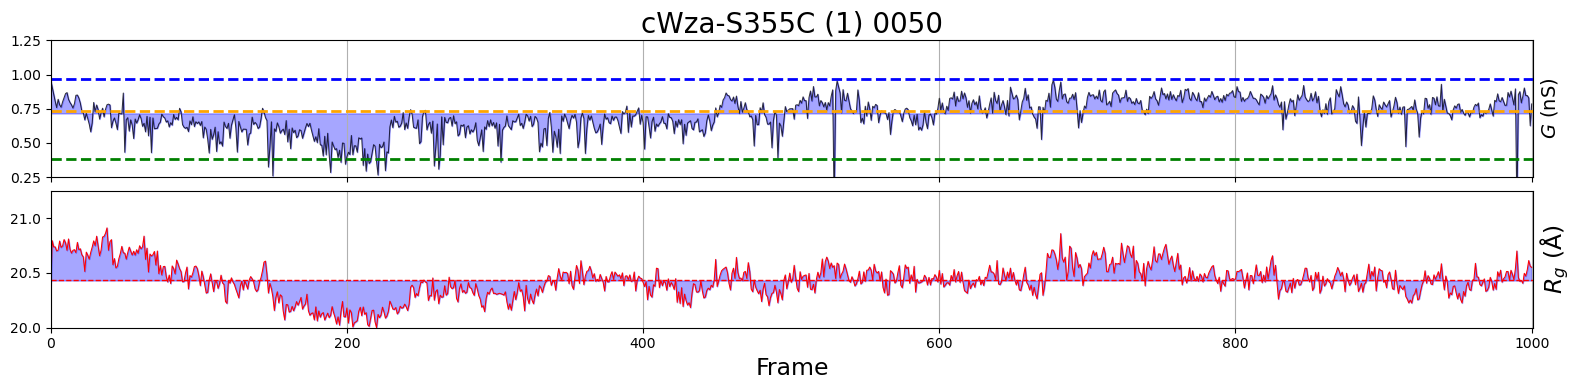

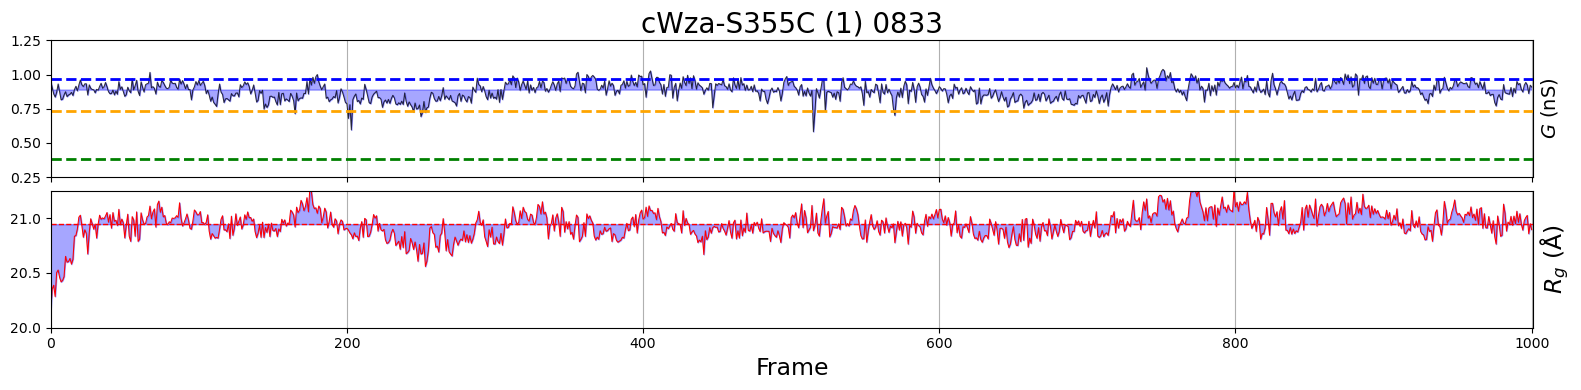

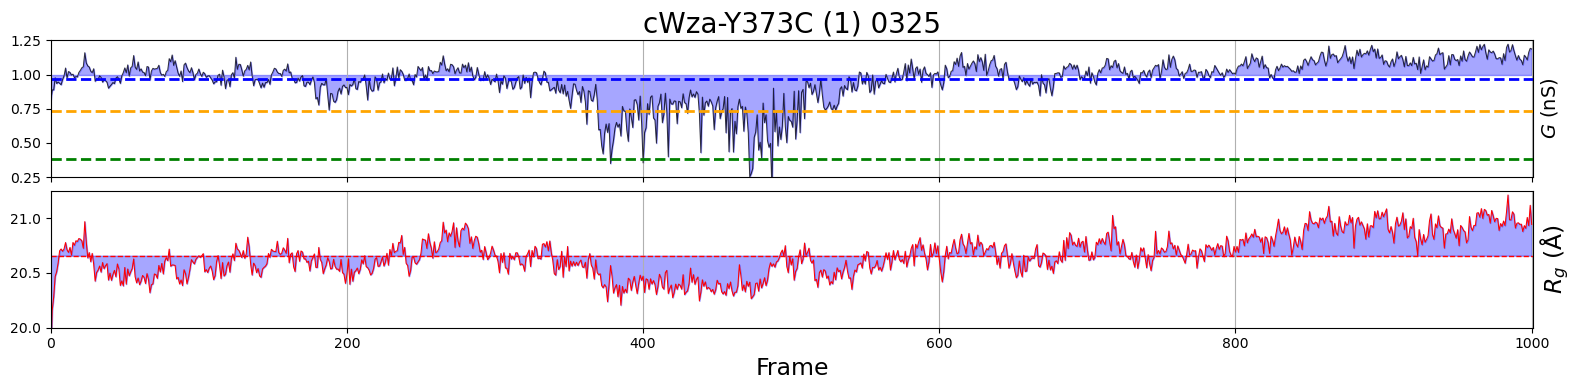

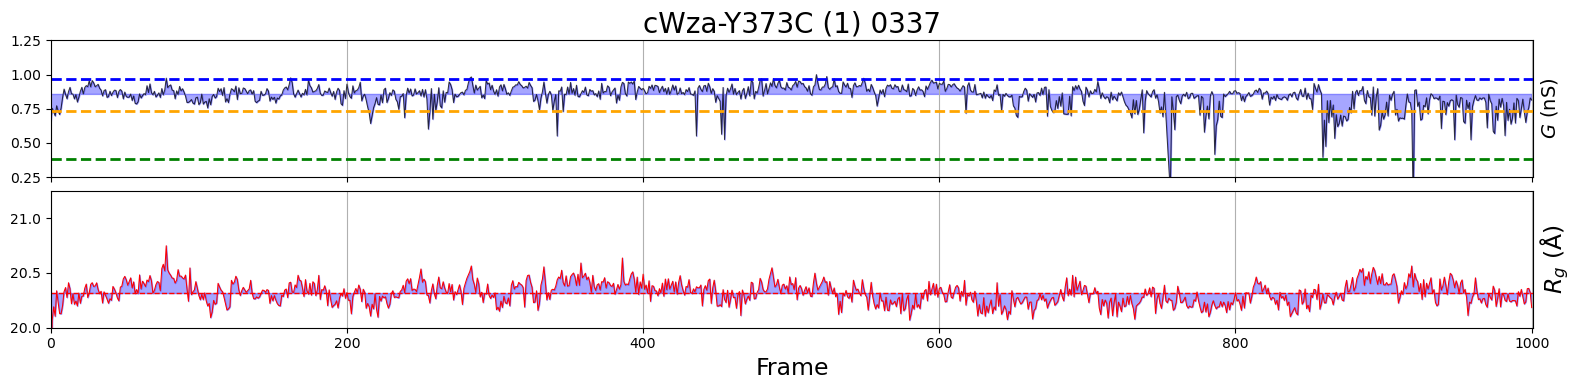

In [6]:
for i in range(len(selected_models)):
    fig,ax = plt.subplots(2,1,figsize=(16,4),sharex=True,dpi=100)
    
    model_name = selected_models[i]
    
    # Conductance timeseries plots
    X = df_conductance[model_name]; X0 = median(X)
    
    ax[0].plot(X, color='black',alpha=0.75, lw=0.75)
    ax[0].fill_between(x=range(len(X)),y1=X0, y2=X, color='blue',alpha=0.35)
    
    ax[0].axhline(y=0.38, label='L-state (EXPTL): 0.38 nS', color='green', linestyle='--', lw=2)
    ax[0].axhline(y=0.73, label='H-state, Y373C (EXPTL): 0.73 nS', color='orange', linestyle='--', lw=2)
    ax[0].axhline(y=0.97, label='H-state (EXPTL): 0.97 nS', color='blue', linestyle='--', lw=2)
    
    ax[0].set_ylabel('$G$ (nS)',fontsize=14)
    
    ax[0].set_xlim(0,1001)
    ax[0].set_ylim(0.25,1.25)
    ax[0].yaxis.set_label_position("right")
    ax[0].xaxis.grid(True)
    
    mutant, conformation, number = model_name.split('_')
    title = mutant+' ('+conformation[-1]+') '+number
    ax[0].set_title(title,fontsize=20)
    
    # Radius of gyration timeseries plots
    Y = rg_results['backbone'][model_name][0]; Y0 = median(Y)
    
    ax[1].plot(Y, color='red',lw=0.75)
    ax[1].fill_between(x=range(len(Y)),y1=Y0, y2=Y, color='blue',alpha=0.35)
    
    ax[1].axhline(Y0,linestyle='--',lw=1,color='red')
        
    ax[1].set_ylabel('$R_{g}$ (Å)',fontsize=17)
    ax[1].set_xlim(0,1001)
    ax[1].set_ylim(20,21.25)
    ax[1].yaxis.set_label_position("right")
    ax[1].xaxis.grid(True)
    ax[1].set_xlabel('Frame',fontsize=17)
    
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.1)
    plt.show()

## Hydrogen-bond timeseries heatmaps

In [7]:
selected_models = ['cWza-S355C_conformation1_0050',
                   'cWza-S355C_conformation1_0833', # stable conformation
                   'cWza-Y373C_conformation1_0325',
                   'cWza-Y373C_conformation1_0337'] # stable conformation

In [8]:
import os
import pickle
import numpy as np
from numpy import NaN

import pandas as pd
import seaborn as sns
from statistics import median

import MDAnalysis as mda
from MDAnalysis.analysis.base import (AnalysisBase,
                                      AnalysisFromFunction,
                                      analysis_class)

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [9]:
leading_hbonds = [('28-ARG', '25-GLU'),
                  ('28-ARG', '32-THR'),
                  ('29-TYR', '25-GLU'),
                  ('18-THR', '22-ASP'),
                  ('6-TRP', '16-THR'),
                  ('21-HIS', '22-ASP'),
                  ('31-LYS', '32-THR'),
                  ('21-HIS', '25-GLU'),
                  ('28-ARG', '22-ASP'),
                  ('28-ARG', '26-THR')]

In [10]:
def get_original_chain(x, peptide_length = 32):
    """
    Return the parent chain number in a homomeric peptide assembly for given a residue number
    """
    N = peptide_length
    if x%N == 0:
        return x//N -1
    else:
        return x//N

def get_original_resnum(x, peptide_length = 32):
    """
    Return the residue number in a homomeric peptide assembly for given a residue number
    """
    N = peptide_length
    if x%N == 0:
        return N
    else:
        return x%N

def find_resid(id, protein_atoms):
    """
    Return original residue number and chain annotations in a homomeric peptide assembly for a given atom id
    """
    f = get_original_chain
    g = get_original_resnum
    return [(str(f(atom.resid)), str(g(atom.resid)), atom.resname) for atom in protein_atoms if id == atom.id]

def intra_to_inter_hbond_counts(counts, u, protein_atoms):
    """
    Compute what percentage of the time intrachain and interchain sidechain H-bonds are found
    """
    interchain_counts = []
    intrachain_counts = []
    for donor, hydrogen, acceptor, count in counts:
        # get biopython objects
        d, h, a = u.atoms[donor], u.atoms[hydrogen], u.atoms[acceptor]
        # get parent labels
        donor_chain, donor_resn, donor_resname = find_resid(d.id, protein_atoms)[0]
        acceptor_chain, acceptor_resn, acceptor_resname = find_resid(a.id, protein_atoms)[0]
        if donor_chain == acceptor_chain:
            intrachain_counts.append(count)
        else:
            interchain_counts.append(count)

    intrachain_frequency = sum(intrachain_counts)/sum(counts.T[-1])
    interchain_frequency = sum(interchain_counts)/sum(counts.T[-1])
    
    return intrachain_frequency, interchain_frequency

In [11]:
aa_3to1 = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
         'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
         'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
         'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

In [12]:
#x = '21-ASP'
fix_label = lambda x:'-'.join([x.split('-')[0], aa_3to1[x.split('-')[1]]])

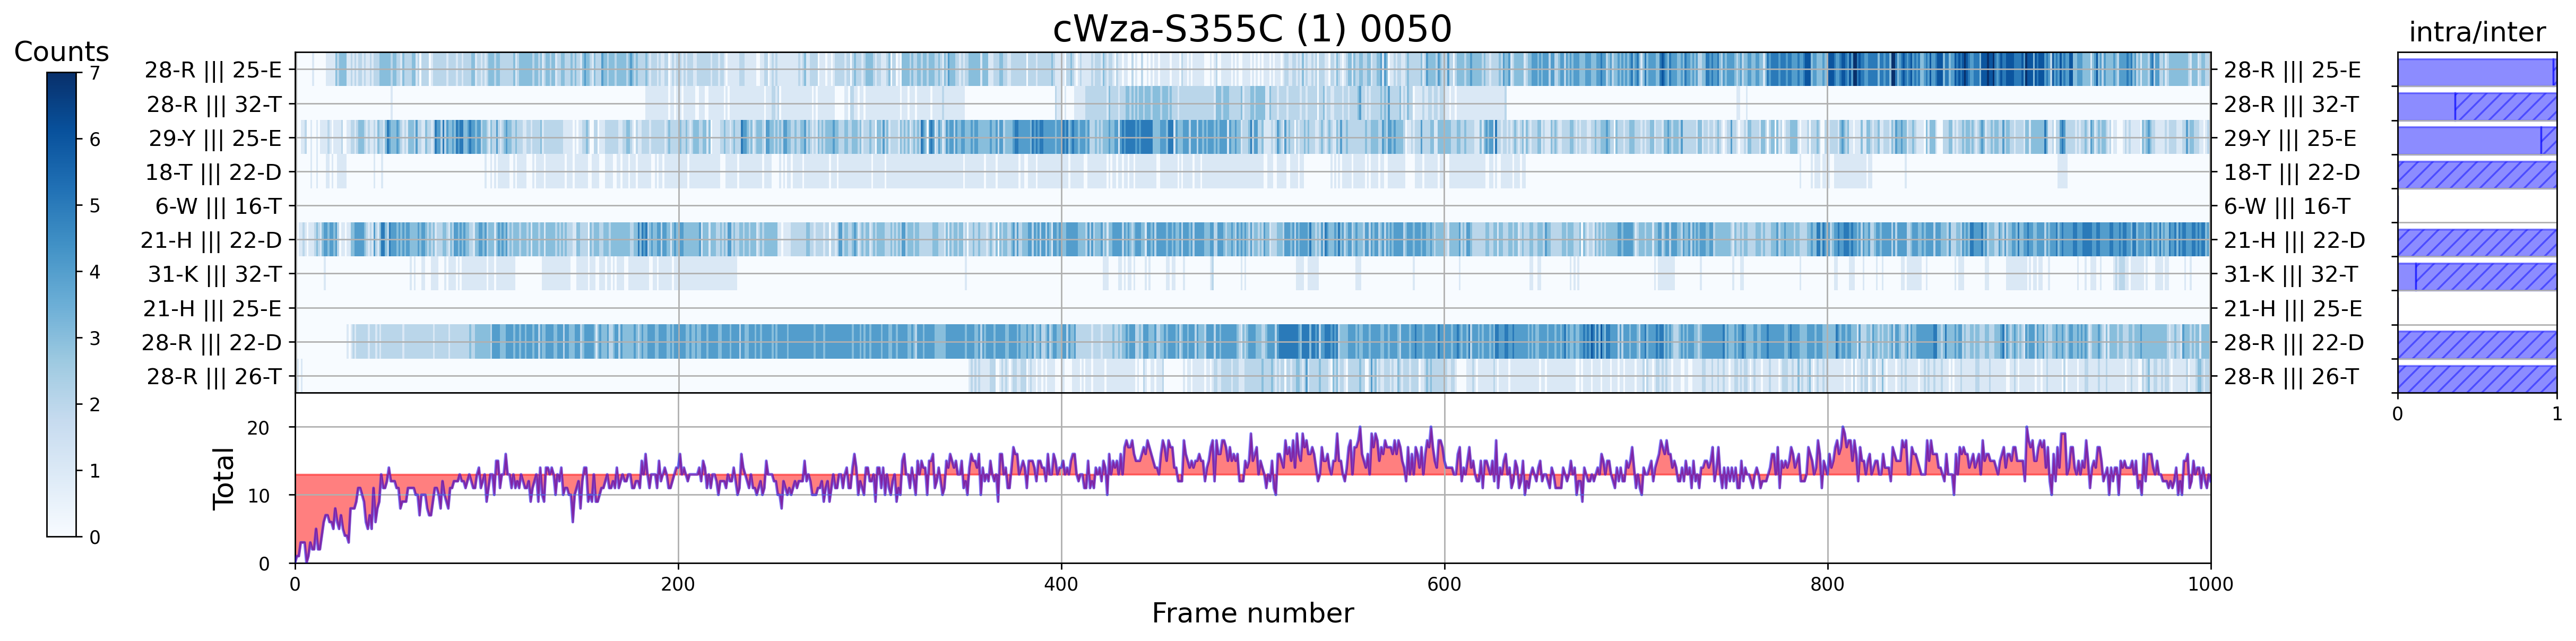

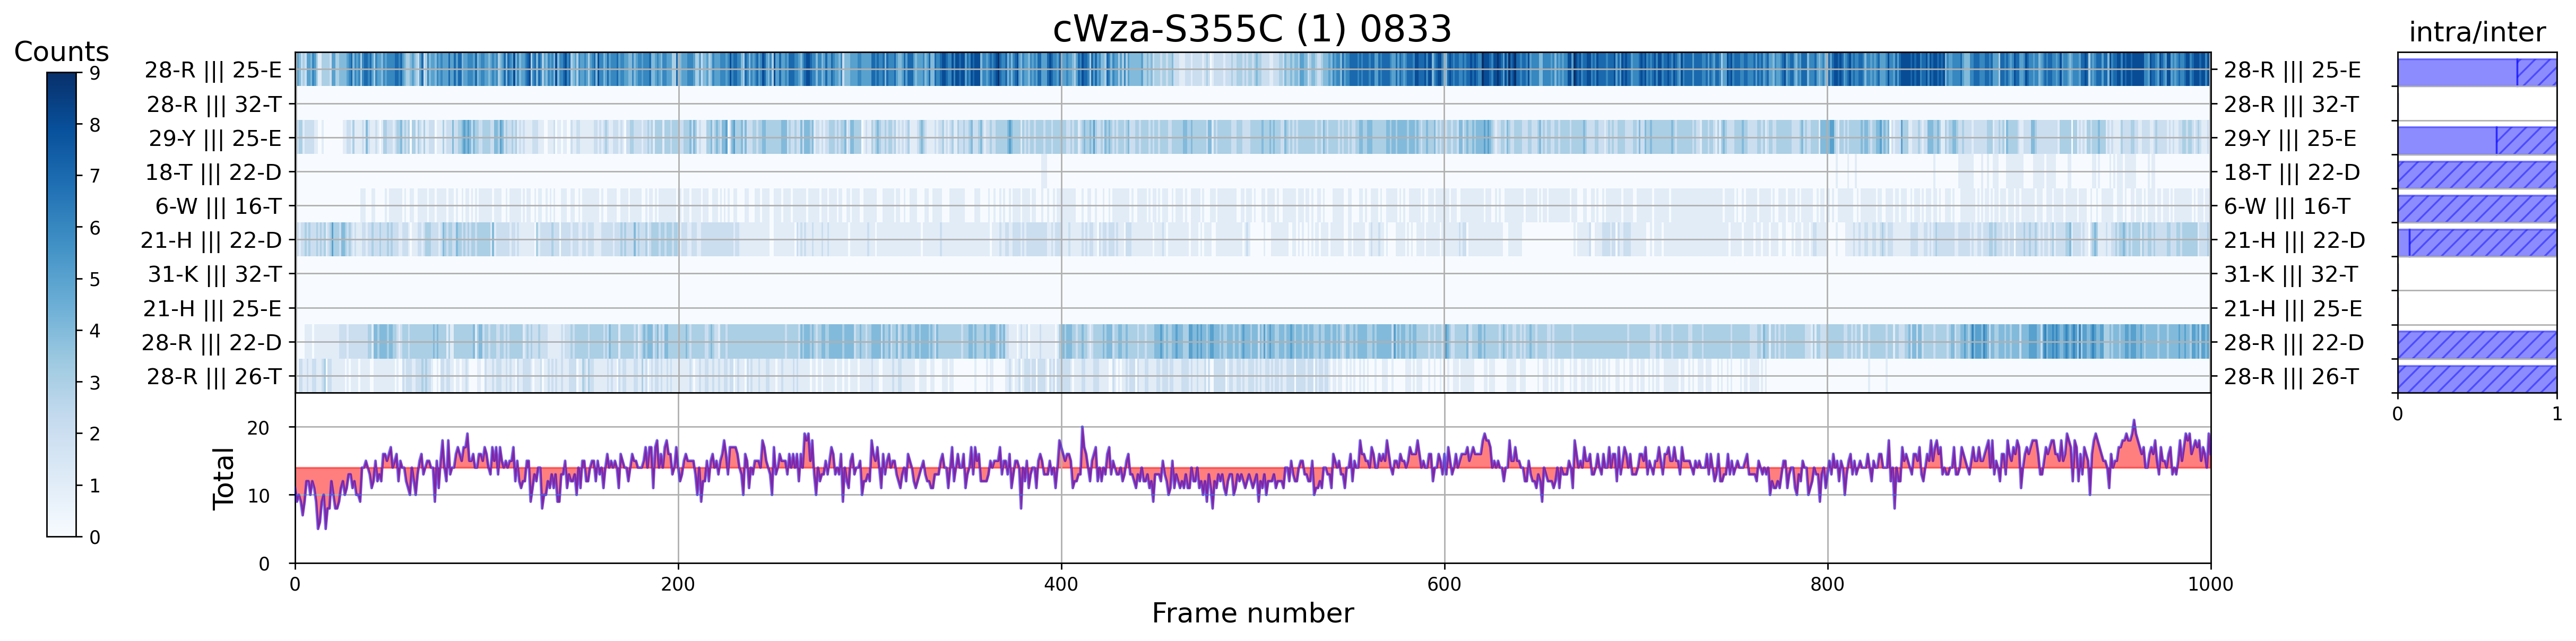

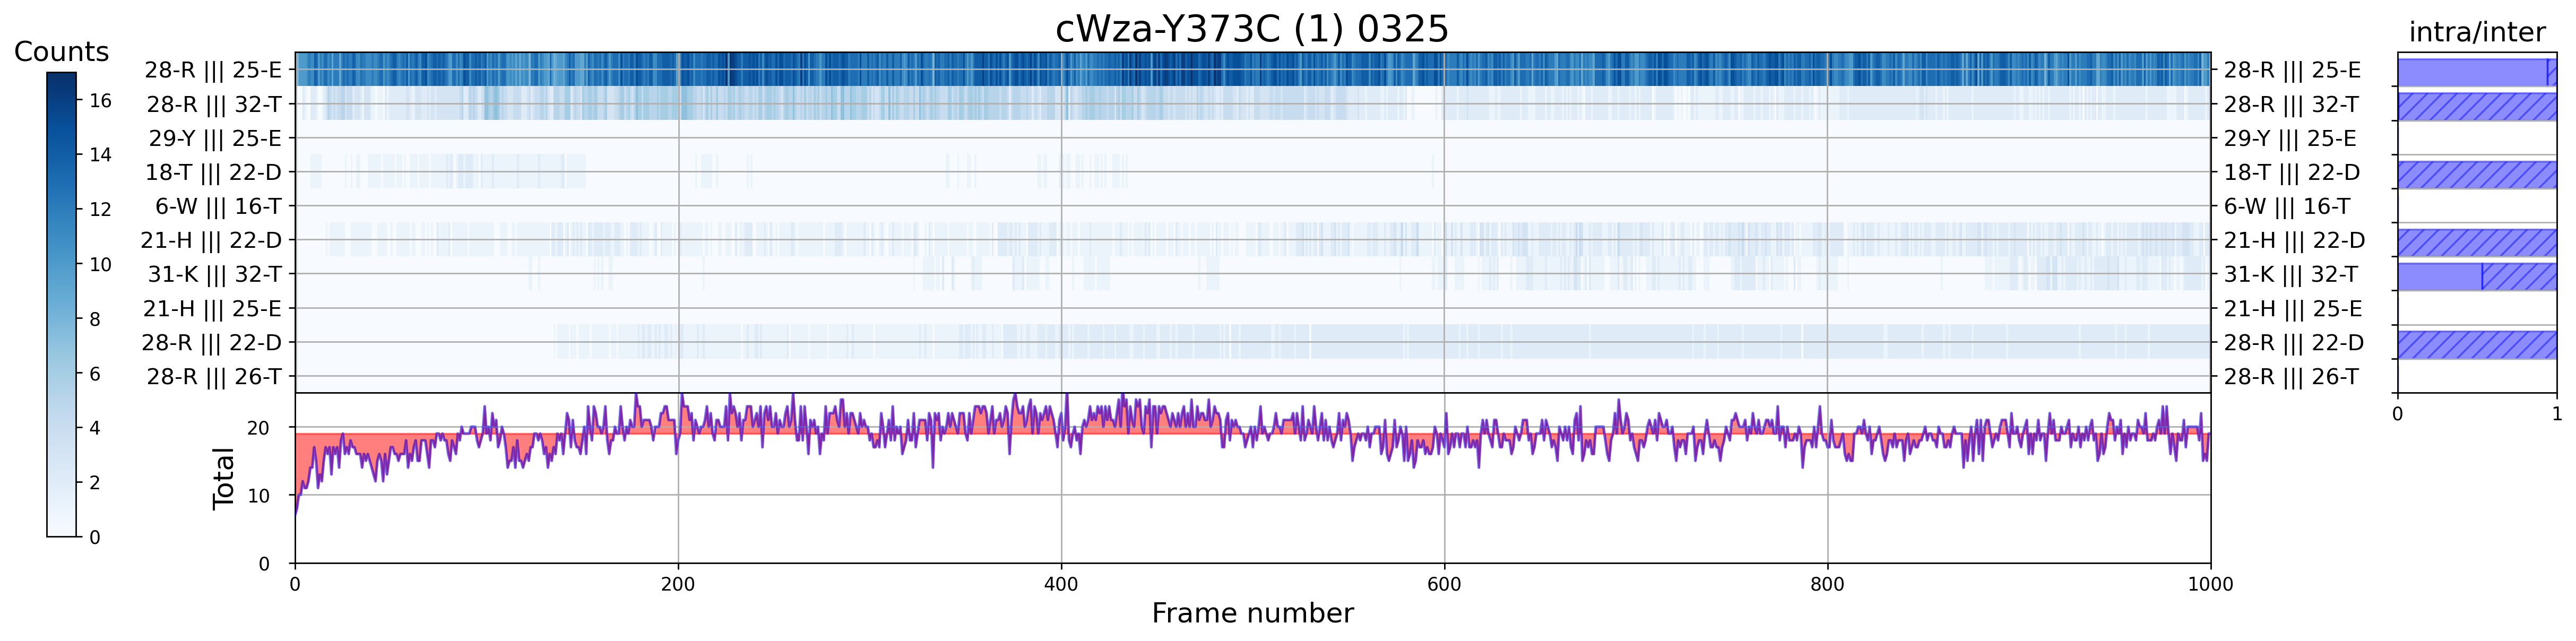

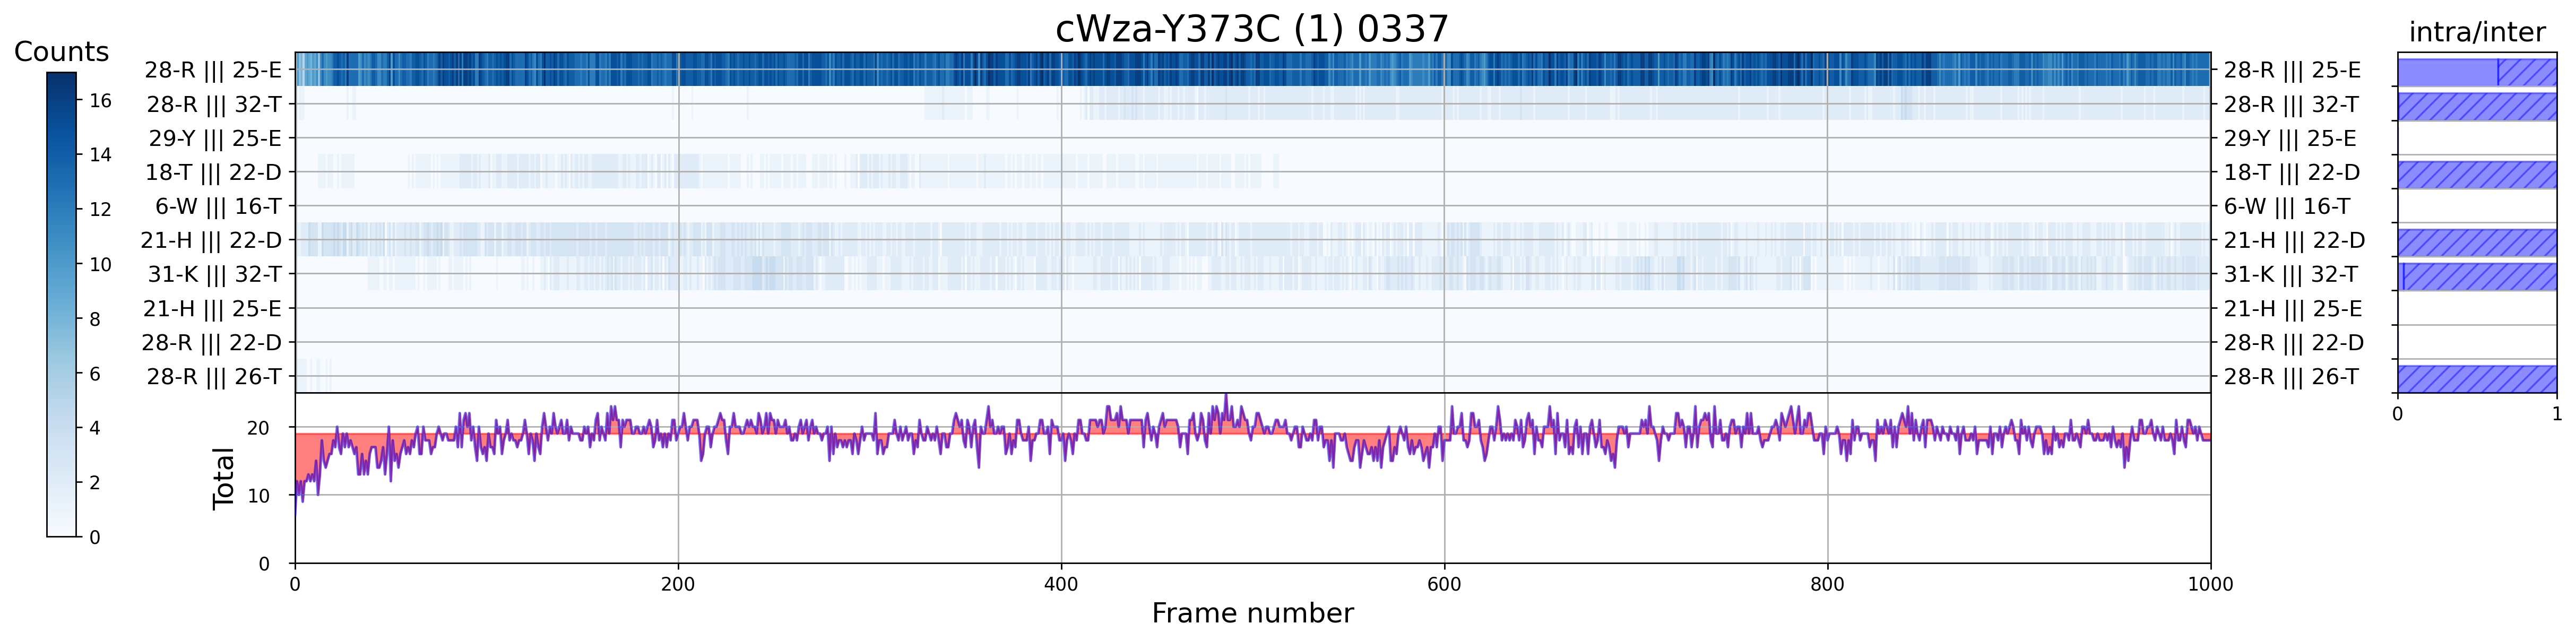

In [13]:
datadir = 'data/'
for model_name in selected_models:
    topology_filepath = os.path.join(datadir, model_name, 'md_100ns.tpr')
    trajectory_filepath = os.path.join(datadir, model_name, 'md_100ns.xtc')

    u = mda.Universe(topology_filepath, trajectory_filepath, in_memory=True)

    hbonds_filename =  os.path.join(datadir, model_name,'md_100ns.hbonds.pickle')
    with open(hbonds_filename,'rb') as fp:
        HBA_data = pickle.load(fp)

    protein_atoms = list(u.select_atoms("protein"))

    X = HBA_data
    counts_data = []
    for key in leading_hbonds:
        if key in X.keys():
            counts = HBA_data[key]['ids']
            counts_data.append(np.array(intra_to_inter_hbond_counts(counts, u, protein_atoms)))
        else:
            counts_data.append((0.0, 0.0))

    counts_data = np.array(counts_data).T

    mutant = model_name
    n_frames = 1001
    X = HBA_data

    data_matrix = np.array([np.array(X[key]['time']) if key in X.keys() else np.zeros(n_frames) for key in leading_hbonds])
    hbonds_list_sorted = np.array(leading_hbonds)
    counts_data_intrachain = counts_data[0][::-1]
    counts_data_interchain = counts_data[1][::-1]
    data_matrix_sorted = data_matrix

    fig = plt.figure(figsize=(22,5), dpi=250)
    gs = fig.add_gridspec(2, 2, width_ratios=[12,1], height_ratios = [2,1])
    axes = (plt.subplot(gs[0, 0]), plt.subplot(gs[0, 1]), plt.subplot(gs[1,0]))

    ax = axes[0]
    im = ax.imshow(data_matrix_sorted, 
                   origin='upper', 
                   vmin = 0,
                   vmax = data_matrix_sorted.max(),
                   interpolation='nearest',
                   aspect='auto',
                   cmap="Blues",
                   alpha=1)

    # customise colorbar
    cbar_ax = fig.add_axes([0.04, 0.15, 0.01, 0.7])
    plt.colorbar(im, cax=cbar_ax, shrink=0.01)
    # customise axes and tick labels
    ax.yaxis.set_tick_params(labelright=True, right=True)
    ax.set_xticklabels([])
    ax.set_yticks(range(len(hbonds_list_sorted)))
    y_labels = [fix_label(x[0])+' ||| '+fix_label(x[1]) for x in list(hbonds_list_sorted)]
    ax.set_yticklabels(y_labels,fontsize=12)
    
    # customise title
    mutant, conformation, number = model_name.split('_')
    title = mutant+' ('+conformation[-1]+') '+number
    ax.set_title(title, fontsize=20)
    ax.grid("True")

    ax = axes[1]
    ax.barh(range(len(hbonds_list_sorted)), counts_data_intrachain, color='blue', align='edge', alpha=0.45, edgecolor='blue')
    ax.barh(range(len(hbonds_list_sorted)), counts_data_interchain, left = counts_data_intrachain, color='blue', hatch='///', align='edge', alpha=0.45, edgecolor='blue')
    ax.set_xticks([0, 1])
    ax.set_xlim(0,1)
    ax.set_yticks(range(len(hbonds_list_sorted)))
    ax.set_yticklabels([])
    ax.set_ylim(0, len(hbonds_list_sorted))
    ax.set_title('intra/inter', fontsize=15)
    ax.grid("True")

    ax = axes[2]
    timeseries = data_matrix_sorted.sum(axis=0)
    ax.plot(timeseries, color='blue',lw=1.5,alpha=0.5,zorder=10)
    ax.fill_between(range(1001),y1=median(timeseries),y2=timeseries, color='red',lw=1,alpha=0.5)
    ax.set_xlabel('Frame number', fontsize=15)
    ax.set_ylabel('Total', fontsize=15)
    #ax.set_yticklabels([])
    ax.tick_params(axis="y",direction="out", pad=10)
    ax.set_xlim(0,1000)
    ax.set_ylim(0, 25)
    ax.grid("True")    
    
    # #fig.tight_layout()
    plt.subplots_adjust(wspace=0.18, hspace=0)
    plt.title("Counts", fontsize=15)

    plt.show()

## Noncovalent contacts timeseries heatmaps

In [14]:
selected_models = ['cWza-S355C_conformation1_0050',
                   'cWza-S355C_conformation1_0833', # stable conformation
                   'cWza-Y373C_conformation1_0325',
                   'cWza-Y373C_conformation1_0337'] # stable conformation

In [15]:
import os
import pickle
import numpy as np
from numpy import NaN

import pandas as pd
import seaborn as sns
from statistics import median

import MDAnalysis as mda
from MDAnalysis.analysis.base import (AnalysisBase,
                                      AnalysisFromFunction,
                                      analysis_class)

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [16]:
aa_3to1 = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
         'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
         'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
         'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

In [17]:
SEQUENCES = {
    'cWza': 'APLVRWNRVISQLVPTITGVHDLTETVRYIKTWPN',
    'cWza-K375C': 'APLVRWNRVISQLVPTITGVHDLTETVRYICTWPN',
    'cWza-S355C': 'APLVRWNRVICQLVPTITGVHDLTETVRYIKTWPN',
    'cWza-Y373C': 'APLVRWNRVISQLVPTITGVHDLTETVRCIKTWPN'
}

In [18]:
contacts_leading =  [(25, 28),
                     (28, 29),
                     (25, 29),
                     (21, 22),
                     (7, 12),
                     (28, 32),
                     (21, 26),
                     (18, 22),
                     (14, 15),
                     (4, 8)]

In [19]:
def get_original_chain(x, peptide_length = 32):
    N = peptide_length
    if x%N == 0:
        return x//N -1
    else:
        return x//N

def get_original_resnum(x, peptide_length = 32):
    N = peptide_length
    if x%N == 0:
        return N
    else:
        return x%N
    
def intra_to_inter_contacts_counts(contacts_data):
    
    minimum_contacts = []
    for contact in set(contacts_data.keys()):
        i, j = contact
        contact_new = (get_original_resnum(i), get_original_resnum(j))
        if contact_new[::-1] not in minimum_contacts:
            minimum_contacts.append(contact_new)

    contacts_grouped = {k:[] for k in minimum_contacts}
    interchain_counts = {k:[] for k in minimum_contacts}
    intrachain_counts = {k:[] for k in minimum_contacts}

    for key in contacts_data.keys():
        i, j = key
        key_new = (get_original_resnum(i), get_original_resnum(j))
        chain_i, chain_j = (get_original_chain(i), get_original_chain(j))

        try:
            contacts_grouped[key_new].append(contacts_data[key])

        except KeyError:
            contacts_grouped[key_new[::-1]].append(contacts_data[key])

        if chain_i == chain_j:
            try:
                intrachain_counts[key_new].append(contacts_data[key] > 0)
            except:
                intrachain_counts[key_new[::-1]].append(contacts_data[key] > 0)

        elif chain_i != chain_j:
            try:
                interchain_counts[key_new].append(contacts_data[key] > 0)
            except KeyError:
                interchain_counts[key_new[::-1]].append(contacts_data[key] > 0)

    intrachain_frequency = {respair: np.sum(intrachain_counts[respair])/np.sum(np.array(contacts_grouped[respair]) > 0) for respair in intrachain_counts.keys() if len(intrachain_counts[respair]) > 0}
    interchain_frequency = {respair: np.sum(interchain_counts[respair])/np.sum(np.array(contacts_grouped[respair]) > 0) for respair in interchain_counts.keys() if len(interchain_counts[respair]) > 0}

    return contacts_grouped, intrachain_frequency, interchain_frequency

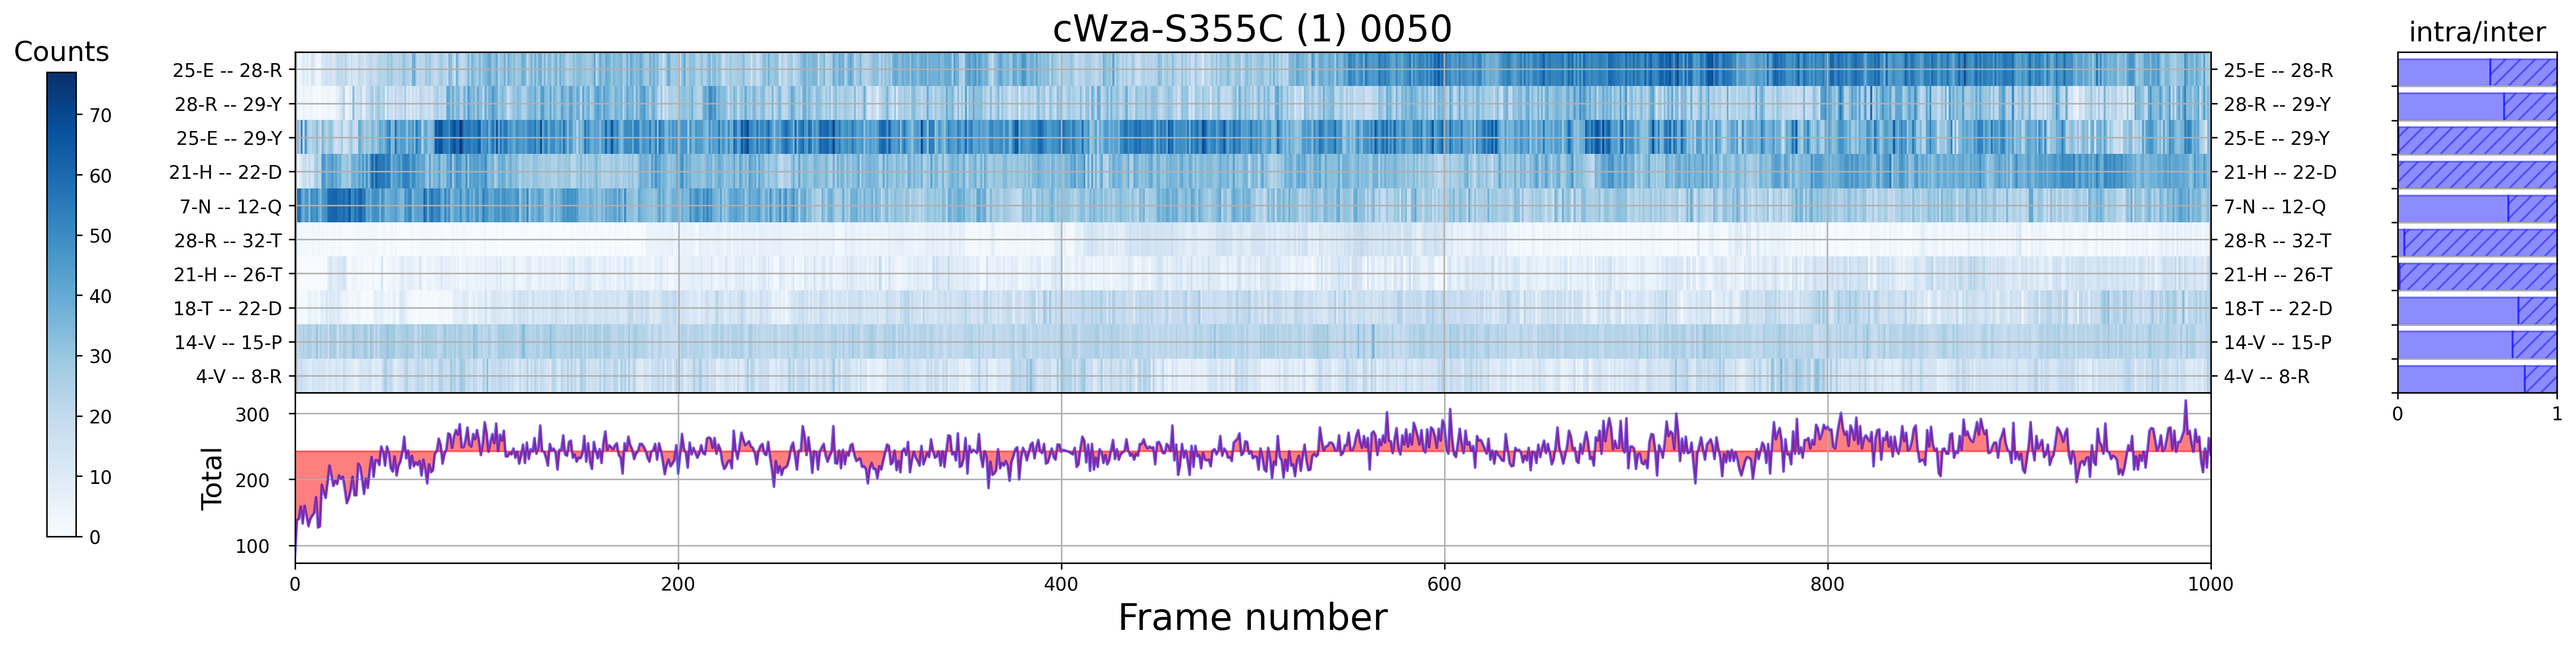

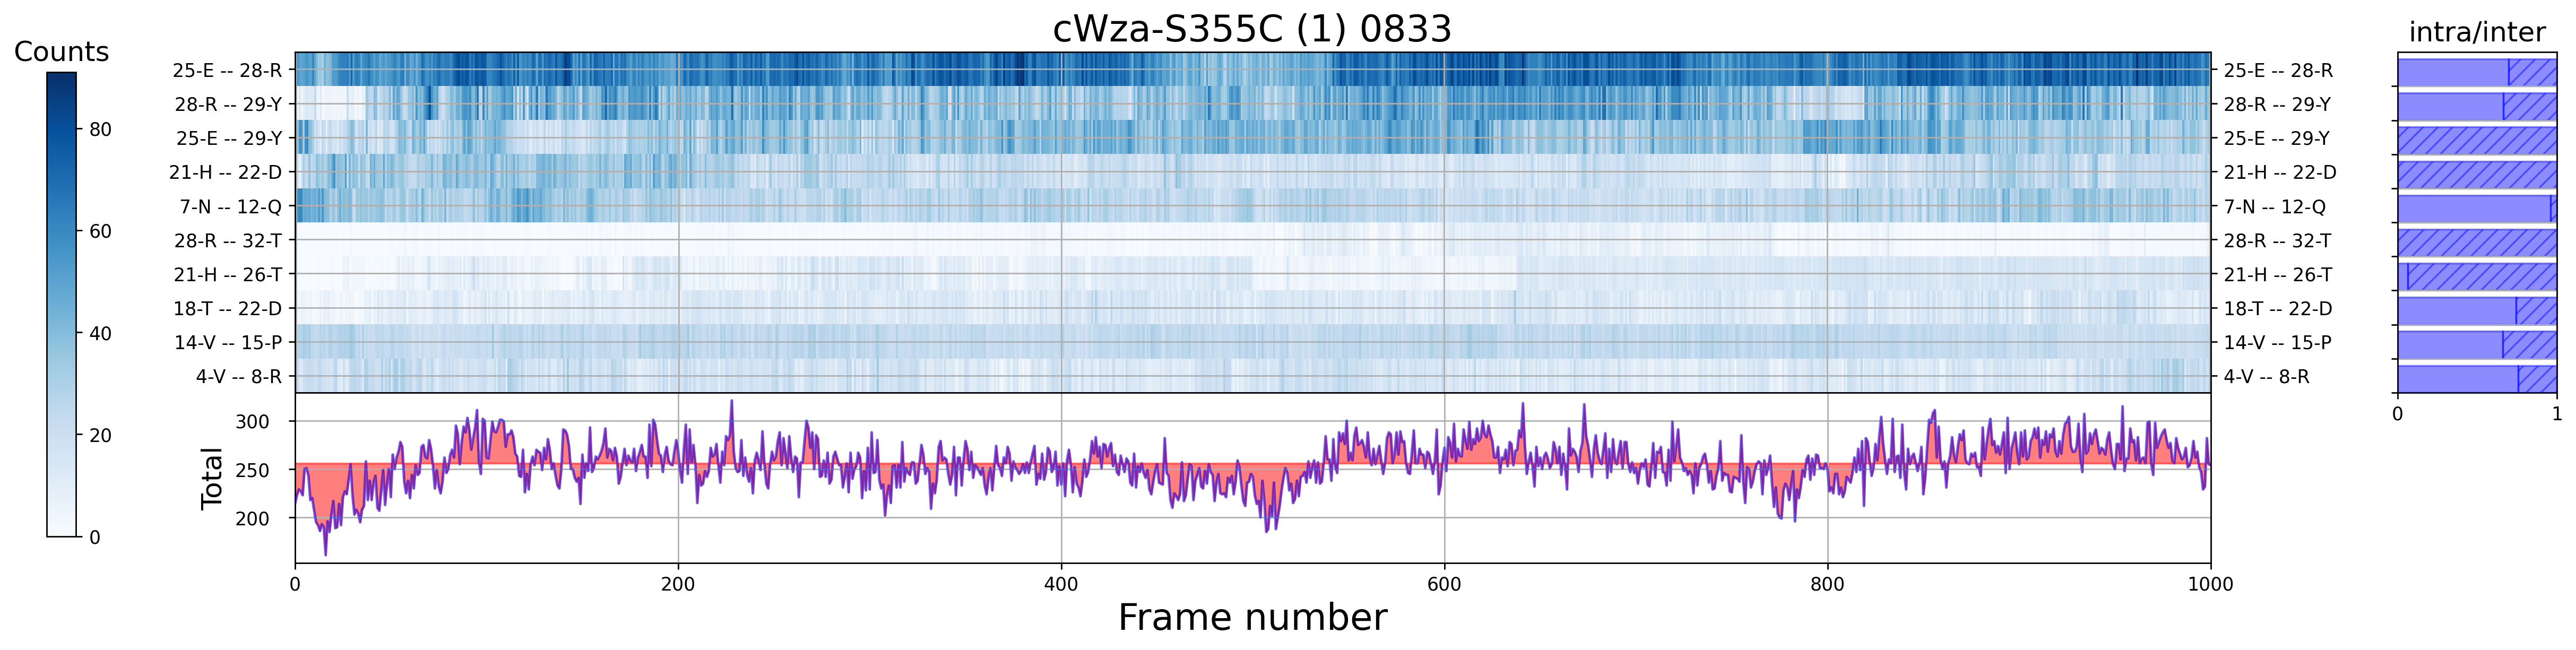

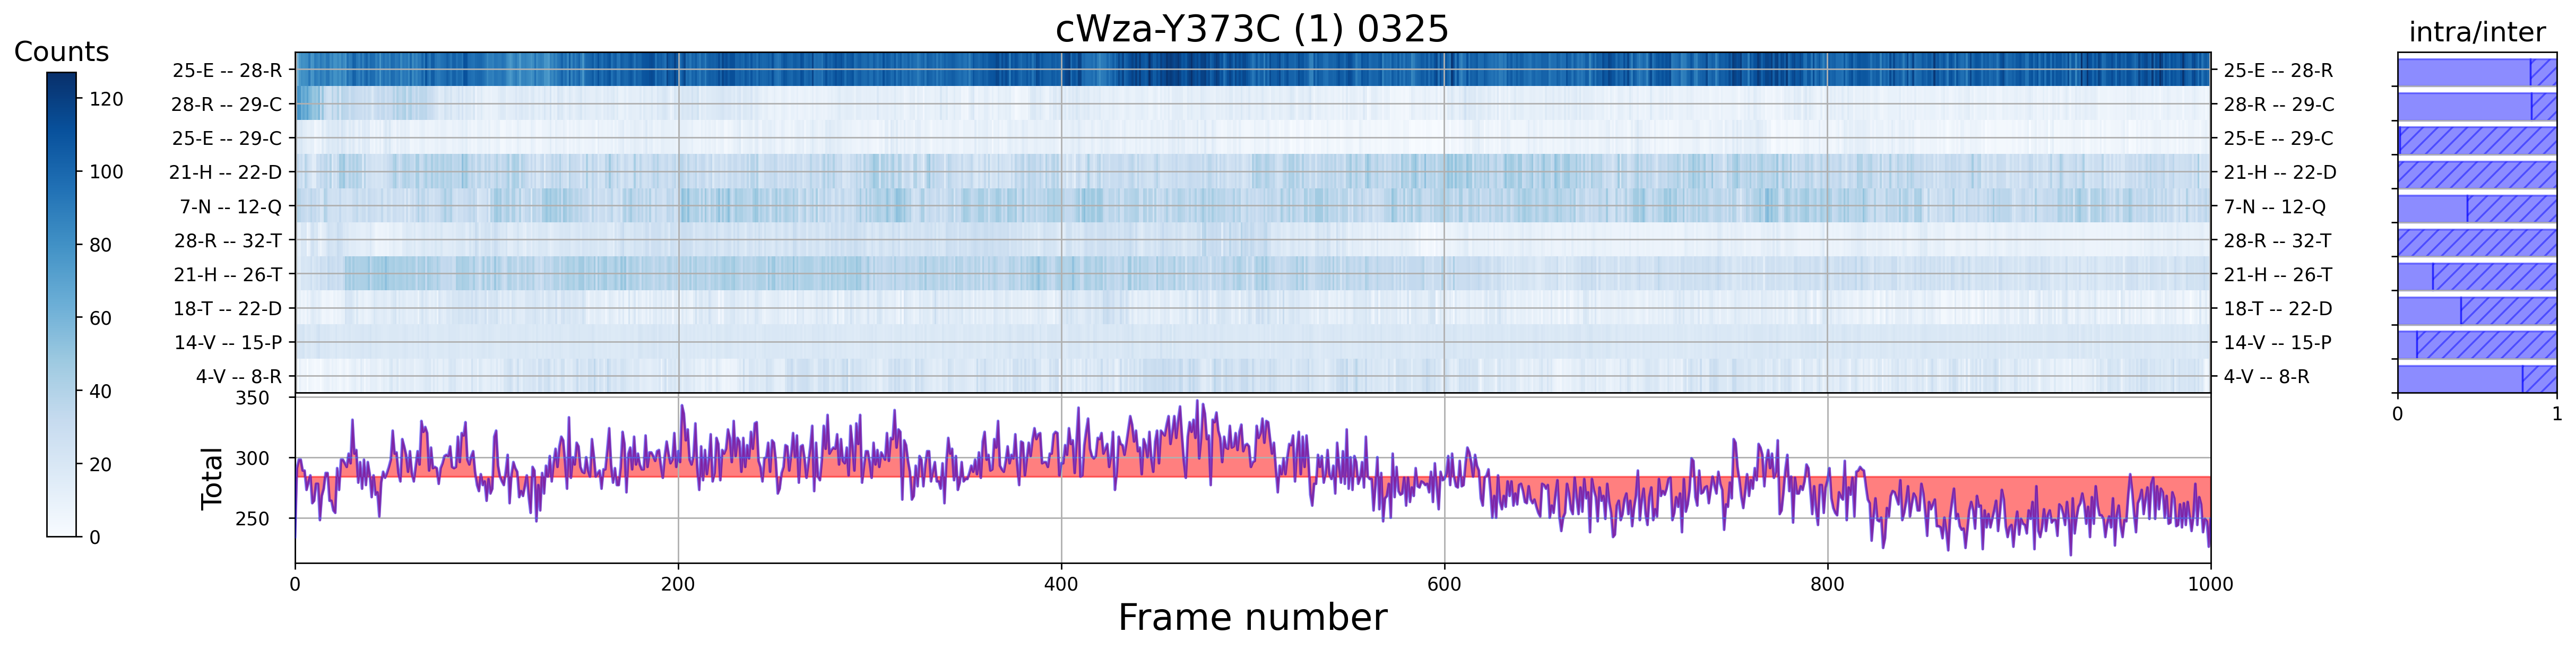

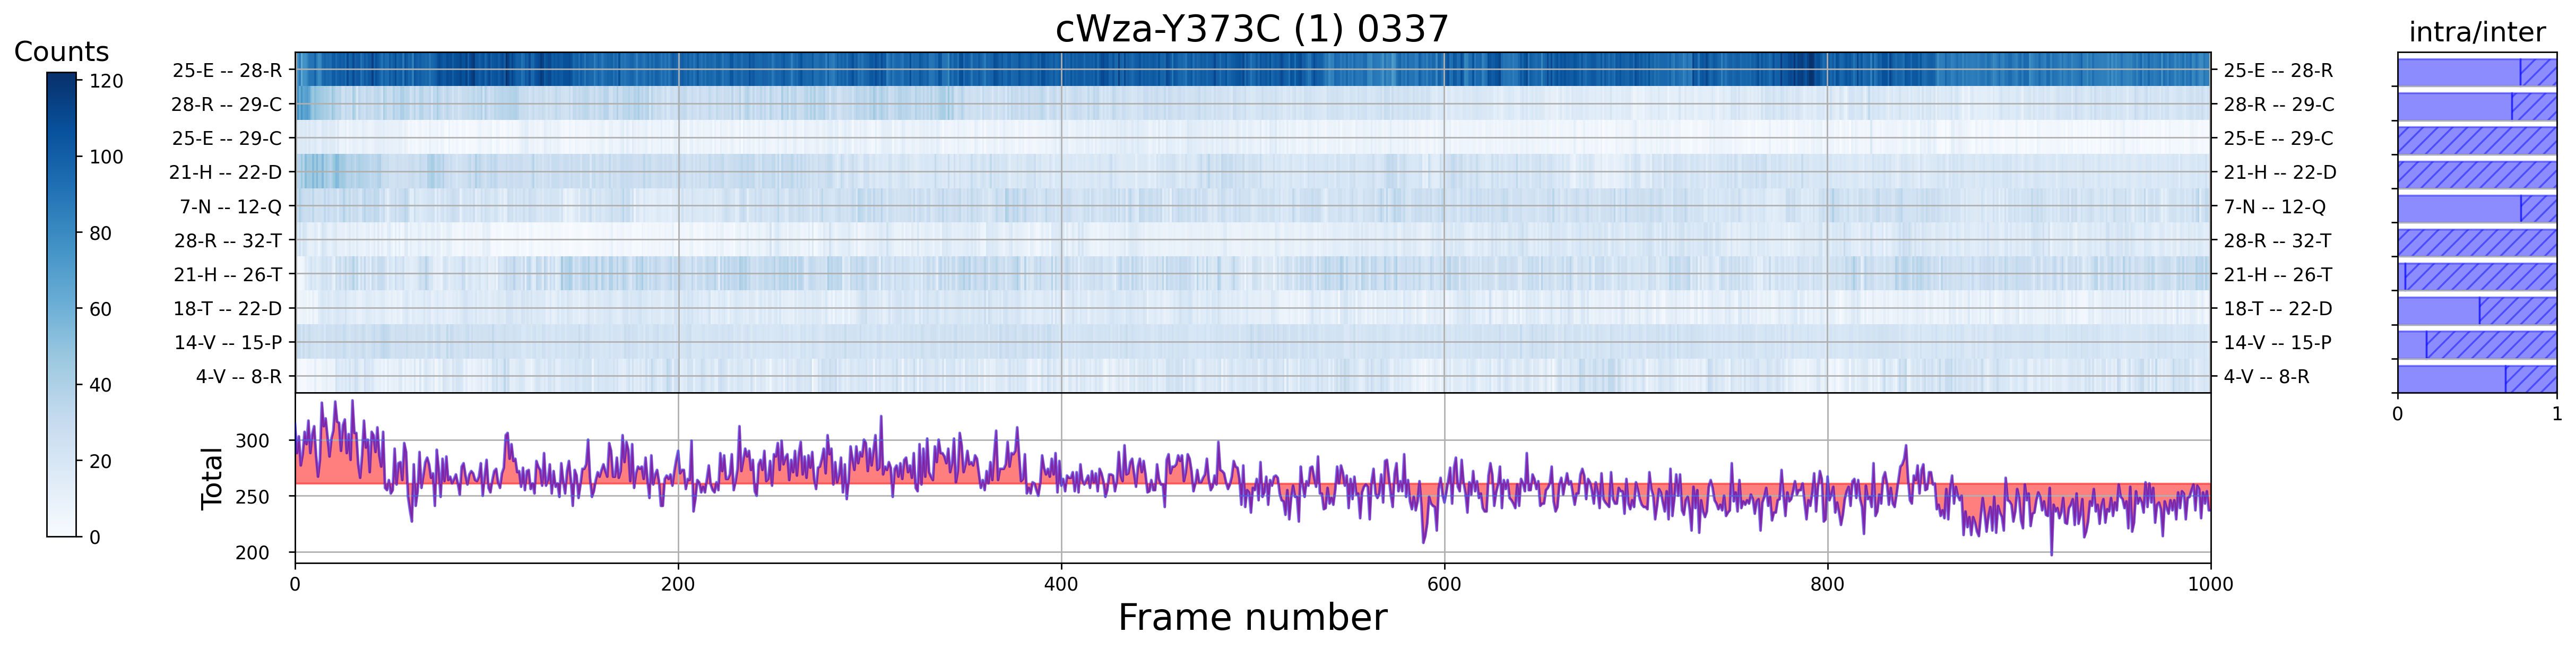

In [20]:
datadir = 'data'
for model_name in selected_models:
    topology_filepath = os.path.join(datadir, model_name, 'md_100ns.tpr')
    trajectory_filepath = os.path.join(datadir, model_name, 'md_100ns.xtc')

    u = mda.Universe(topology_filepath, trajectory_filepath, in_memory=True)

    filename = 'md_100ns.contacts.pickle'

    with open(os.path.join(datadir, model_name, filename),'rb') as fp:
        contacts_data = pickle.load(fp)

    contacts_grouped, intrachain_frequency, interchain_frequency = intra_to_inter_contacts_counts(contacts_data)

    counts_data_intrachain = []
    for respair in contacts_leading:
        if (respair in intrachain_frequency.keys()) or (respair[::-1] in intrachain_frequency.keys()):
            try:
                counts_data_intrachain.append(intrachain_frequency[respair])
            except KeyError:
                counts_data_intrachain.append(intrachain_frequency[respair[::-1]])

        else:
            counts_data_intrachain.append(0.0)

    counts_data_interchain = []
    for respair in contacts_leading:
        if (respair in interchain_frequency.keys()) or (respair[::-1] in interchain_frequency.keys()):
            try:
                counts_data_interchain.append(interchain_frequency[respair])
            except KeyError:
                counts_data_interchain.append(interchain_frequency[respair[::-1]])

        else:
            counts_data_interchain.append(0.0)

    # counts_data = np.array([counts_data_intrachain, counts_data_interchain])


    # Sum over all contact timeseries per residue combination
    n_frames = 1001
    contacts_nonredundant = {k:sum(v) for k,v in contacts_grouped.items() if (len(v)>1)}

    # Filter out contacts according to leads
    contacts_filtered = {}
    for respair in contacts_leading:
        if (respair in list(contacts_nonredundant.keys())): 
            contacts_filtered[respair] = contacts_nonredundant[respair]
        elif (respair[::-1] in list(contacts_nonredundant.keys())):
            contacts_filtered[respair] = contacts_nonredundant[respair[::-1]]
        else:
            contacts_filtered[respair] = np.zeros(n_frames)

    X = contacts_filtered
    data_matrix = np.array(list(X.values()))

    fig = plt.figure(figsize=(22,5), dpi=250)
    gs = fig.add_gridspec(2, 2, width_ratios=[12,1], height_ratios = [2,1])
    axes = (plt.subplot(gs[0, 0]), plt.subplot(gs[0, 1]), plt.subplot(gs[1,0]))

    # Heatmap
    ax = axes[0]
    im = ax.imshow(data_matrix, 
                   origin='upper', 
                   vmin = 0,
                   vmax = data_matrix.max(),
                   interpolation='nearest',
                   aspect='auto',
                   cmap="Blues",
                   alpha=1)

    # customise colorbar
    cbar_ax = fig.add_axes([0.04, 0.15, 0.01, 0.7])
    plt.colorbar(im, cax=cbar_ax, shrink=0.01)

    # Custom x-axis labels
    contacts_labels = []
    seq = SEQUENCES[model_name.split('_')[0]]
    for contact in contacts_leading:
        resn_A = contact[0]
        resn_B = contact[1]
        label = str(resn_A)+'-'+seq[resn_A-1]+' -- '+str(resn_B)+'-'+seq[resn_B-1]
        contacts_labels.append(label)

    # customise axes and tick labels
    ax.yaxis.set_tick_params(labelright=True, right=True)
    ax.set_xticklabels([])
    ax.set_yticks(range(len(contacts_leading)))
    ax.set_yticklabels(contacts_labels,fontsize=10)

    # customise title
    mutant, conformation, number = model_name.split('_')
    title = mutant+' ('+conformation[-1]+') '+number
    ax.set_title(title, fontsize=20)
    ax.grid("True")

    # Barplots
    ax = axes[1]
    ax.barh(range(len(contacts_filtered)), 
            counts_data_intrachain, 
            color='blue', 
            align='edge', 
            alpha=0.45, 
            edgecolor='blue')

    ax.barh(range(len(contacts_filtered)), 
            counts_data_interchain, 
            left = counts_data_intrachain, 
            color='blue', 
            hatch='///', 
            align='edge', 
            alpha=0.45, 
            edgecolor='blue')

    ax.set_xticks([0, 1])
    ax.set_xlim(0,1)
    ax.set_yticks(range(len(contacts_filtered)))
    ax.set_yticklabels([])
    ax.set_ylim(0, len(contacts_filtered))
    ax.set_title('intra/inter', fontsize=15)
    ax.grid("True")

    # Timeseries: total counts
    ax = axes[2]
    timeseries = data_matrix.sum(axis=0)
    ax.plot(timeseries, color='blue',lw=1.5,alpha=0.5,zorder=10)
    ax.fill_between(range(1001),y1=median(timeseries),y2=timeseries, color='red',lw=1,alpha=0.5)
    ax.set_xlabel('Frame number', fontsize=20)
    ax.set_ylabel('Total', fontsize=15)
    ax.tick_params(axis="y",direction="out", pad=10)
    ax.set_xlim(0,1000)
    # ax.set_ylim(0,250)
    ax.grid("True")

    # #fig.tight_layout()
    plt.subplots_adjust(wspace=0.18, hspace=0)
    plt.title("Counts", fontsize=15)
    
    plt.show()

#     filename = model_name+'_heatmap.png'
#     png_outpath = os.path.join(datadir, 'figs','stable_conductance_contact_heatmaps',filename)
#     plt.savefig(png_outpath, bbox_inches='tight')
#     plt.close(fig)